<a href="https://colab.research.google.com/github/enakai00/JAX_workshop/blob/main/1_Introduction_to_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX の基本機能

## 注意事項

このノートブックは、GPU ランタイムを使用します。無償版の Colaboratory では GPU ランタイムの使用時間に制限があるため、長時間使用し続けると、一定期間（12〜24時間程度）GPU ランタイムが使用できなくなります。

**このノートブックを実行し終わったら、「ランタイム」メニューから「ランタイムを接続解除して削除」を選択して、GPUランタイムを停止しておいてください。**

## 事前準備

JAX/Flax/Optaxのライブラリーをインストールします。

In [1]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.6/185.6 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 6.0 MB/s eta 0:00:00
flax                          0.6.1
jax                           0.3.25
jaxlib                        0.3.25+cuda11.cudnn805
optax                         0.1.3


## DeviceArray オブジェクトを用いた数値計算


通常の NumPy を `np`、JAX 版の numpy モジュールを `jnp` という名前でインポートします。

In [2]:
import numpy as np

import jax
from jax import numpy as jnp

NumPy を使って、行列の計算（行列 M を二乗した後、各成分の平均値を求める）を行う関数を定義します。

In [3]:
def matrix_calc(m):
    return np.mean(np.dot(m, m))

NumPy の array オブジェクトを用いて、5000 x 5000 サイズの巨大な行列を用意します。

ここでは、3 x 3 部分をサンプルとして表示しています。

In [4]:
size = 5000
m = np.random.random([size, size])
m[:3, :3]

array([[0.21018713, 0.93789099, 0.92954632],
       [0.26213402, 0.13083575, 0.51450946],
       [0.64215905, 0.86242423, 0.87112384]])

用意した行列に対して、先ほど定義した関数を実行します。

In [5]:
%%time
print(matrix_calc(m))

1250.2688656942428
CPU times: user 11.4 s, sys: 281 ms, total: 11.7 s
Wall time: 6.38 s


同じ関数を JAX を使って定義します。

使用するモジュールが `np` から `jnp` に変わっている点に注意してください。

また、関数定義の直前に `@jax.jit` をつけて、事前コンパイルを適用しています。

In [6]:
@jax.jit
def matrix_calc_jax(m):
    return jnp.mean(jnp.dot(m, m))

先ほど用意した 5000 x 5000 サイズの行列を格納した array オブジェクトを DeviceAraay オブジェクトに変換します。

DeviceArray オブジェクトの内容は、GPU のメモリー上に保存されて、GPU による計算処理の対象となります。

In [7]:
m = jnp.asarray(m)
m[:3, :3]

DeviceArray([[0.21018714, 0.937891  , 0.9295463 ],
             [0.26213402, 0.13083574, 0.51450944],
             [0.64215904, 0.86242425, 0.87112385]], dtype=float32)

JAX 版の関数を実行します。

初回の実行時は、事前コンパイル処理が行われるので、実行時間が少し長くなります。

（今回の場合は、それでも、NumPy 版の関数よりも高速です。）

In [8]:
%%time
print(matrix_calc_jax(m))

1250.2688
CPU times: user 1.87 s, sys: 196 ms, total: 2.07 s
Wall time: 3.87 s


同じ関数を再度、実行します。2回目は、事前コンパイル済みのバイナリーが利用されるので、高速に実行されます。

In [9]:
%%time
print(matrix_calc_jax(m))

1250.2688
CPU times: user 57.1 ms, sys: 0 ns, total: 57.1 ms
Wall time: 60.4 ms


## JAX での乱数の取り扱い方法

一般に、プログラミング言語で使用する乱数は、シードの値から一定のルールで新しい値を生成する「疑似乱数」になります。新しい乱数を発生するごとに、（内部に保存された）シードの値を自動更新していきます。

[一般的なプログラミング言語での乱数発生方法]

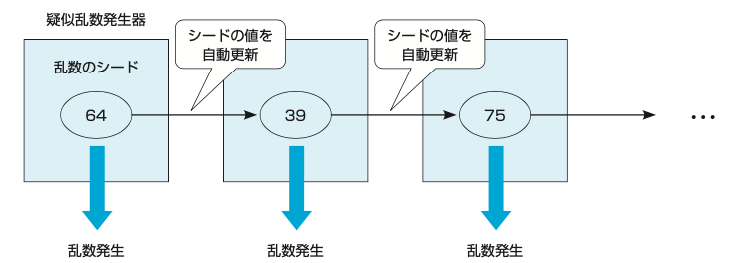

一方、JAX で乱数を発生する際は、自分で用意した乱数のシードを明示的に渡す必要があります。

（シードの値を自分で管理することにより、実行ごとに確実に同一の乱数列を発生させることができます。）

[JAX での乱数発生方法]

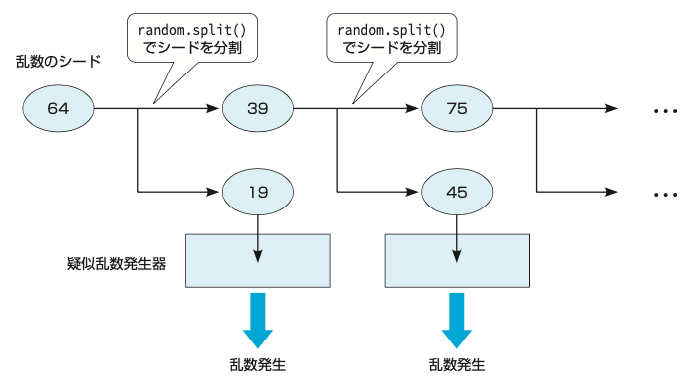

シードを用意する方法は、次のようになります。

乱数を扱うモジュール `random` をインポートします。

In [10]:
import jax.random as random

規定のシード値 `random.PRNGKey(0)` を分割して、新しいシード値を2つ用意します。

（それぞれ `key` と `key1` に保存します。）

In [11]:
key, key1 = random.split(random.PRNGKey(0))

`key1` に保存したシードを用いて乱数を発生します。

JAX を用いて発生した乱数なので、結果は DeviceArray オブジェクトで返ります。

In [12]:
random.normal(key1)

DeviceArray(-1.2515389, dtype=float32)

同じシードを用いると同じ値が発生するので、一度使用したシードは再利用しないでください。

In [13]:
random.normal(key1)

DeviceArray(-1.2515389, dtype=float32)

先ほど `key` に保存したシードを再度分割して、新しいシード値を2つ用意して、その一方（`key1` に保存したシード）を使用します。

In [14]:
key, key1 = random.split(key)
random.normal(key1)

DeviceArray(-0.58665055, dtype=float32)

これ以降は、同じ手続き（`key` に保存したシードを再分割して、一方を利用する）を繰り返します。

In [15]:
key, key1 = random.split(key)
random.normal(key1)

DeviceArray(0.48648307, dtype=float32)

## JAX による微分計算

グラフを描画するためのモジュールをインポートします。

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 12})

グラフを描画する関数を用意します。

この関数の内容は、理解する必要はありません。

In [17]:
def plot3d(x_range, y_range, z_function, grad_function):
    xs = np.linspace(x_range[0], x_range[1], 100)
    ys = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(xs, ys)
    points = np.c_[np.ravel(X), np.ravel(Y)]
    Z = np.array([z_function(x, y) for x, y in points])
    Z = Z.reshape(X.shape)

    fig = plt.figure(figsize=(16, 8))
    subplot = fig.add_subplot(1, 2, 1, projection='3d')
    subplot.plot_surface(X, Y, Z, cmap=plt.cm.Blues_r)
    subplot = fig.add_subplot(1, 2, 2)
    subplot.contourf(X, Y, Z, levels=50,
                     cmap=plt.cm.Blues_r, alpha=0.5)

    xs = np.linspace(x_range[0], x_range[1], 15)
    ys = np.linspace(y_range[0], y_range[1], 15)
    X, Y = np.meshgrid(xs, ys)
    points = np.c_[np.ravel(X), np.ravel(Y)]
    G = [grad_function(x, y) for x, y in points]
    U = np.array([u for u, v in G])
    V = np.array([v for u, v in G])
    U = U.reshape(X.shape)
    V = V.reshape(X.shape)

    subplot.set_aspect('equal')
    subplot.quiver(X, Y, U, V, color='red',
                   scale=16, headlength=6, headwidth=7)
    subplot.set_position([0.5, 0.2, 0.25, 0.50])
    subplot.set_xticks([])
    subplot.set_yticks([])

2変数関数 `h(x1, x2)` を定義します。

$$h(x_1, x_2) = \frac{1}{4}(x_1^2 + x_2^2)$$

ここでは、`@jax.jit` を指定して事前コンパイルを適用しています。

In [18]:
@jax.jit
def h(x1, x2):
    z = (1/4) * (x1**2 + x2**2)
    return z

関数 `jax.grad()` で `h(x1, x2)` を微分して得られる関数 `nabla_h` を用意します。

引数 `(0, 1)` は、0 番目（`x1`）と 1 番目（`x2`）の引数による微分を計算するという指定で、これにより、それぞれの変数で偏微分した結果を並べた勾配ベクトルが得られます。

$$
\nabla h(x_1,x_2) = \begin{pmatrix}
\frac{\partial h(x_1, x_2)}{\partial x_1} \\
\frac{\partial h(x_1, x_2)}{\partial x_2}
\end{pmatrix}
$$

In [19]:
nabla_h = jax.grad(h, (0, 1))

関数 `jax.jit()` を得られた関数 `nabla_h` に適用して、事前コンパイルを適用した新しい関数 `nabla_h_precompiled` を作ります。

※ 自分で定義した関数に事前コンパイルを適用する際は、`@jax.jit` を指定します。一方、今回のように、計算で得られた関数に事前コンパイルを適用する際は、関数 `jax.jit()` を使用します。

In [20]:
nabla_h_precompiled = jax.jit(nabla_h)

例として、点 (1.0, 1.0) における勾配ベクトルの値を計算してみます。

JAX を用いて計算しているので、結果は DeviceArray オブジェクトで返ります。

In [21]:
nabla_h_precompiled(1.0, 1.0)

(DeviceArray(0.5, dtype=float32, weak_type=True),
 DeviceArray(0.5, dtype=float32, weak_type=True))

関数全体のグラフ、および、勾配ベクトルのグラフを描きます。

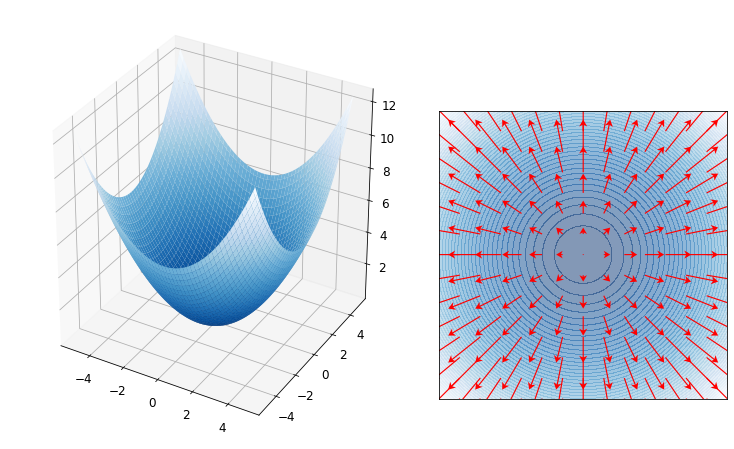

In [22]:
plot3d((-5, 5), (-5, 5), h, nabla_h_precompiled)

同様の処理をまた別の関数に適用してみます。

$$h(x_1, x_2) = 2\sin x_1\cdot\sin x_2$$

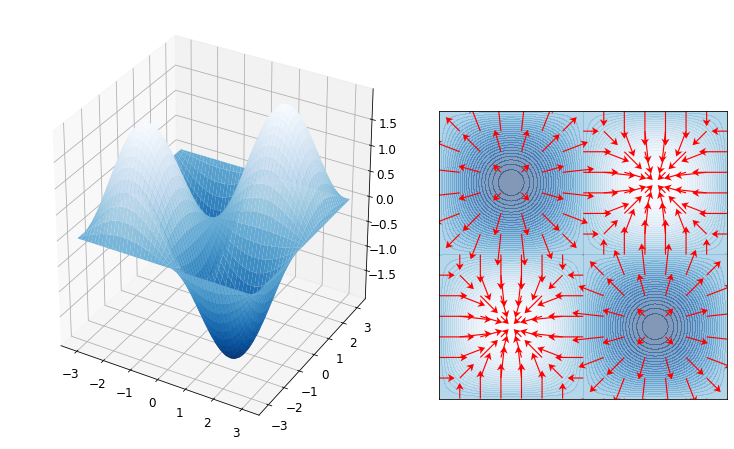

In [23]:
@jax.jit
def h(x1, x2):
    z = 2 * jnp.sin(x1) * jnp.sin(x2)
    return z

nabla_h = jax.jit(jax.grad(h, (0, 1)))
plot3d((-np.pi, np.pi), (-np.pi, np.pi), h, nabla_h)